## Setting the Environment
This section of the code imports libraries, loads in the data sets. Several data sets have been explored, only the medium_1.csv was left to use for the final model. 
As the original data sets have not been randomly split, it would not make sense to train the machine learning model on one data set and then test it on another, therefore, the data set will be split into a training and testing sets.

In [8]:
# ID5059 - Knowledge Discovery & Data Mining
# Coursework Assignment 1 - Individual
# Deadline: Friday 24th February 2023 (week 6), 9pm
# Student: Erna Kuginyte 220013309

################################################################################
###################### IMPORT LIBRARIES, DATA FRAME ############################
################################################################################

# Load libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from zlib import crc32
# Correlation matrix plots
from pandas.plotting import scatter_matrix
# This line runs on Jupyter Notebook only
#get_ipython().run_line_magic("matplotlib", "inline")

# Read the dataset from a file
# Specify type "string" for the "bed" and "dealer_zip" attributes to avoid 
#       errors interpreting them as numbers
cars = pd.read_csv("/Users/ernakuginyte/Desktop/Projects for Applications/Cars-Predictions-_PYTHON/data/used_cars_data_medium_1.csv", \
    dtype = {"bed": "string", "dealer_zip": "string"})
# Comment out the other data sets
#cars = pd.read_csv("/Users/ernakuginyte/Desktop/Projects for Applications/Cars-Predictions-_PYTHON/data/used_cars_data_small_1.csv", \
#    dtype = {"bed": "string", "dealer_zip": "string"})
#cars = pd.read_csv("/Users/ernakuginyte/Desktop/Projects for Applications/Cars-Predictions-_PYTHON/data/used_cars_data_medium_2.csv", \
#    dtype = {"bed": "string", "dealer_zip": "string"})

## Data Exploration
This part of the code explores the data set by checking data set description and its variables, size of data; by plotting distributions of variables.

                     vin back_legroom   bed bed_height bed_length  \
0      4T1G11BK1LU006835        38 in  <NA>        NaN        NaN   
1      JF2SJABC6HH562440        38 in  <NA>        NaN        NaN   
2      1N4BL4CV1KC141133      35.2 in  <NA>        NaN        NaN   
3      NMTKHMBX6LR113244      31.7 in  <NA>        NaN        NaN   
4      KM8J3CA28HU394246      38.2 in  <NA>        NaN        NaN   
...                  ...          ...   ...        ...        ...   
27867  2HGFC2F64LH532457      37.4 in  <NA>        NaN        NaN   
27868  2GNAXJEV8J6125077      39.7 in  <NA>        NaN        NaN   
27869  2HGFC2F68LH532848      37.4 in  <NA>        NaN        NaN   
27870  1J8GR48K58C227110      35.5 in  <NA>        NaN        NaN   
27871  JTMBFREV3HJ130313      37.2 in  <NA>        NaN        NaN   

             body_type cabin              city  city_fuel_economy  \
0                Sedan   NaN  West Springfield               25.0   
1      SUV / Crossover   NaN     

/Users/ernakuginyte/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

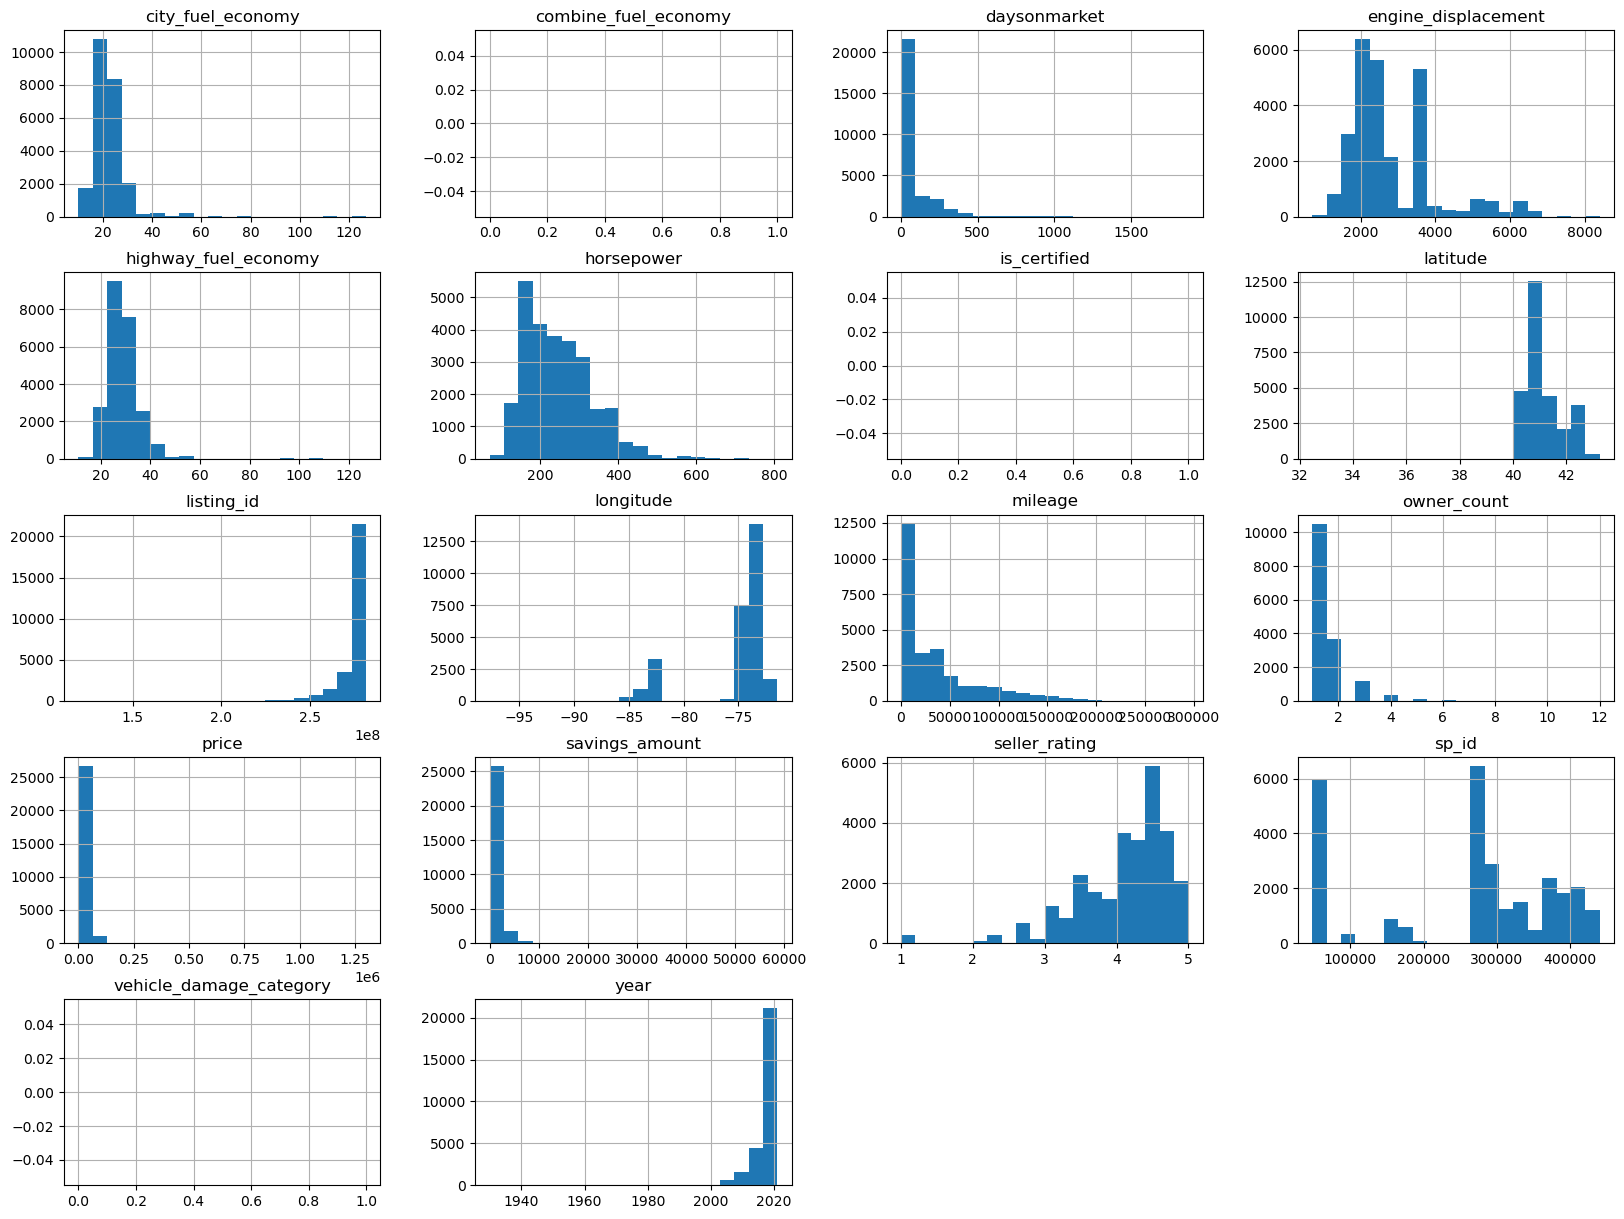

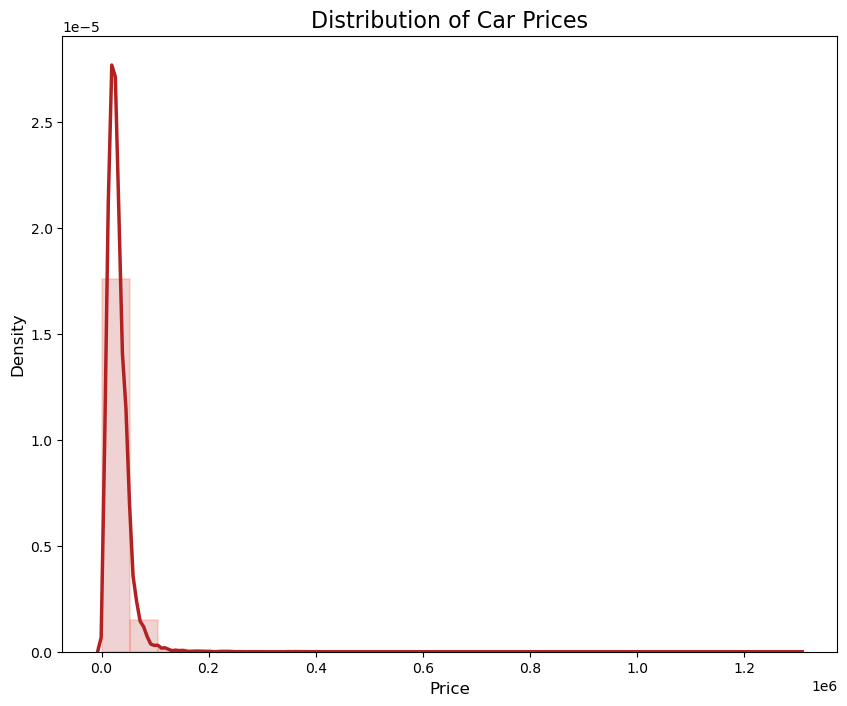

In [2]:
################################################################################
############################# EXPLORE THE DATA #################################
################################################################################

# Clear the maximum number of columns to be displayed, so that all will be visible
pd.set_option("display.max_columns", None)
# Check the basic statistics of the data
cars.describe()
# Display the data frame
print(cars)
# Explore numeric columns visually
cars.hist(bins = 20, figsize = (20, 15)) 

########################### EXPLORE THE PRICE VARIABLE ##########################

# Inspect the price variable by plotting a histogram with a curve on top.
# Explore numeric columns visually.
# Set the figure size
plt.figure(figsize = (10, 8))
# Plot the histogram with the kde curve 
sns.distplot(cars["price"], kde = True, bins = 25, color = "firebrick", \
             hist_kws = {"alpha": 0.2, "edgecolor": "tomato", "linewidth": 1.5}, \
                kde_kws = {"linewidth": 2.5})
# Set the title and axis labels)
# Set the title and axis labels
plt.title("Distribution of Car Prices", fontsize = 16)
plt.xlabel("Price", fontsize = 12)
plt.ylabel("Density", fontsize = 12)

## Data Wrangling
Data wrangling section has been split into several parts. First part deals with duplicates in the data set, variables with more than 25% missing values are dropped, other missing values are filled with the variable's means, some redundant variables are deleted, some missing variables are filled in accordance with another variable's values.

In [3]:
################################################################################
############################# DATA WRANGLING ###################################
################################################################################

################################ DUPLICATES ####################################

# Firstly, check for duplicates
print(cars.duplicated().sum()) 
# Drop duplicates
cars = cars.drop_duplicates()

########################## DEAL WITH MISSING VALUES ############################

# Deal with the missing values.
# Check which columns have only missing values and drop them.
cars = cars.dropna(axis = 1, how = "all")

# Add 0 to "owner_count" in missing values if "is_new" is True
cars.loc[(cars["is_new"] == True) & (cars["owner_count"].isnull()), "owner_count"] = 0

# Check which columns have some missing values.
# First find the number of missing values in each column.
na_columns = cars.isna().sum()
# Save the column names with missing values
cols_with_na = list(na_columns[na_columns > 0].index)
# Print the column names with number of missing values 
#    out of total number of rows in the data set
for col in cols_with_na:
    print(f"{col}: {na_columns[col]} missing values out of {cars.shape[0]}")

### clean_df - Cleans dataframe columns with missing data;
###            if more than 25% of rows are missing, the whole column will be dropped;
###            else, add median numeric values to the numeric data, string or object data won"t be modified.  
#   INPUT:
#              df - data frame with latent values.
#   OUTPUT:
#              df_cleaned - cleaned data frame.
def clean_df(df):
    
    # Firstly check if the input value is of correct type
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input argument incorrect, it should be a Data Frame! :)")
    # Check if the data frame has any missing values
    if not df.isnull().values.any():
        raise ValueError("Your data frame does not have any missing values, hooray! :)")    
        
    # Find the number of missing values in each column
    na_columns = df.isna().sum()

    # Calculate the percentage of missing values in each column
    na_columns_percent = na_columns / df.shape[0]

    # Get the names of the columns with more than 25% missing values
    cols_to_drop = list(na_columns_percent[na_columns_percent > 0.25].index)

    # Drop the columns with more than 25% missing values
    df_cleaned = df.drop(cols_to_drop, axis = 1)

    # Replace the missing values in the remaining columns with the median value
    # if the column is numeric, otherwise leave the values as is
    for col in df_cleaned.columns:
        # First check if the data type is numeric
        if df_cleaned[col].dtype in ["float64", "int64"]:
            # Fill the missing values with medians
            df_cleaned[col].fillna(df_cleaned[col].median(), inplace = True)
            
    # Return the cleaned data frame
    return df_cleaned

# Apply the function and save the cleaned data frame
cars = clean_df(df = cars)
# Print names of non-numeric columns with the number of missing values.
# Get the number of missing values in each non-numeric column
na_string_columns = cars.isna().sum()

# Get the names of non-numeric columns with missing values
cols_with_na = list(na_string_columns[na_string_columns > 0].index)

# Print the names of non-numeric columns with the number of missing values
for col in cols_with_na:
    print(f"{col}: {na_string_columns[col]} missing values out of {cars.shape[0]}")

####################### ADD MEAN TO THE MISSING VALUES #########################

### fill_na_mean - Take away the " in", "in", " gal" measurement units from data set 
###                variables and converts it to a numeric object;
###                Fills latent variables with mean value.
#   INPUT:  
#                  variables_inches - names of variables that have " in" inches measurement;
#                                     also has some missing values.
#   OUTPUT: 
#                  data - cleaned data frame.
def fill_na_mean(data, vars):

    # Firstly check if the input value is of correct type.
    # Check if data is a data frame.
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input argument incorrect, it should be a Data Frame! :)")
    # Check if the data frame has any missing values
    if not data.isnull().values.any():
        raise ValueError("Your data frame does not have any missing values, hooray! :)")
    # Check if the variables_inches vector is not empty
    if len(vars) == 0:
        raise ValueError("Variable list is empty! :)")

        # For each variable in the variables_inches list
    for variable in vars:

        # Check if the variable type is object
        if data[variable].dtype == object:
            # Remove the "in" and "gal" from the values
            data[variable] = data[variable].str.replace(" in", "").str.replace(" gal", "").\
                str.replace("in", "").str.replace("--", "")
            # Convert the string variables to numeric
            data[variable] = pd.to_numeric(data[variable], errors = "coerce")
        # Fill missing values with the mean
        data[variable] = data[variable].fillna(data[variable].mean())

    # Return the wrangled data frame
    return data

# Create a list of variables to fill the NAs with mean
variables_inches = ["back_legroom", "front_legroom", "height", "length", \
    "wheelbase", "width", "fuel_tank_volume"]

# Apply the fill_na_mean function and save the cleaned data frame
cars = fill_na_mean(data = cars, vars = variables_inches)

# The variables that have too many missing values or cannot be filled manually
#   as they are character variables; main_picture_url useless for this analysis
columns_to_drop = ["engine_cylinders", "fuel_type", "main_picture_url", "trimId", \
    "major_options", "power", "torque", "transmission_display", "trim_name", \
        "wheel_system", "wheel_system_display", "main_picture_url", "description", \
            "maximum_seating", "engine_type", "vin", "body_type"]
# Drop the unwanted variables
cars.drop(columns_to_drop, axis = 1, inplace = True)

########################## FILL OTHER MISSING VALUES ###########################

# Deal with missing values in listing_color and exterior_color variables.
# Replace the "UNKNOWN" values in listing_color with values from exterior_color.
cars.loc[cars["listing_color"] == "UNKNOWN", "listing_color"] = cars["exterior_color"]
# Replace the "None" values in exterior_color with values in listing_color
cars.loc[cars["exterior_color"] == "None", "exterior_color"] = cars["listing_color"]
# Delete rows where listing_color is UNKNOWN and exterior_color is None
cars = cars.loc[(cars["listing_color"] != "UNKNOWN") | (cars["exterior_color"].notna())]

# Calculate the mean of the "owner_count" column
mean_owner_count = np.nanmean(cars["owner_count"])
# Round the mean to the nearest integer
rounded_mean_owner_count = int(round(mean_owner_count))
# Replace missing values with the rounded mean
cars["owner_count"] = cars["owner_count"].fillna(rounded_mean_owner_count)

# Check which variables have missing values
print(cars.isnull().sum())

0
back_legroom: 1269 missing values out of 27872
bed: 27661 missing values out of 27872
bed_height: 25802 missing values out of 27872
bed_length: 25802 missing values out of 27872
body_type: 108 missing values out of 27872
cabin: 27401 missing values out of 27872
city_fuel_economy: 4250 missing values out of 27872
description: 1664 missing values out of 27872
engine_cylinders: 781 missing values out of 27872
engine_displacement: 1334 missing values out of 27872
engine_type: 781 missing values out of 27872
fleet: 11485 missing values out of 27872
frame_damaged: 11485 missing values out of 27872
franchise_make: 9253 missing values out of 27872
front_legroom: 1269 missing values out of 27872
fuel_tank_volume: 1269 missing values out of 27872
fuel_type: 633 missing values out of 27872
has_accidents: 11485 missing values out of 27872
height: 1269 missing values out of 27872
highway_fuel_economy: 4250 missing values out of 27872
horsepower: 1334 missing values out of 27872
isCab: 11485 missi

#### Data Wrangling. Encoding character variables. Dates
As per title, the code here converts some of the character variables to categories (only the ones with not too many possible categories), other character variables are encoded to become numerical. Date variable is converted.

In [4]:
################################################################################
###################### DEAL WITH OTHER OBJECT VARIABLES ########################
################################################################################

################################ CATEGORICAL ###################################

# Import to change the character variables to categorical
from sklearn.preprocessing import OrdinalEncoder
# Convert categories from text to numbers
ordinal_encoder = OrdinalEncoder()
# Define which variables to change to categorical
char_variables = ["city", "franchise_dealer", \
    "is_new", "listing_color", "make_name", "model_name", \
        "sp_name", "transmission", "dealer_zip", "year"]
# Categorise variables
for variables in char_variables:
    cars[variables] = cars[variables].astype("category")

################################# NUMERICAL #####################################

# Import to change the character variables to numerical
from sklearn.preprocessing import LabelEncoder
# Encode character variables to numerical ones
# Create a label encoder object
encoder = LabelEncoder()
# Variables to convert to numerical ones
char_to_num_variables = ["exterior_color", "city", "interior_color", "make_name", \
    "model_name", "sp_name"]
# Convert the character columns to numerical variables using transform function
for var in char_to_num_variables:
    encoder.fit(cars[var])
    cars[var+"_code"] = encoder.transform(cars[var].astype(str)) 

#################################### DATE ########################################

# Convert listed_date from object to Unix timestamp
cars["listed_date"] = pd.to_datetime(cars["listed_date"]).astype(int) // 10 ** 9

#### Data Wrangling. Extra Variables
It is sometimes useful to include extra variables that make sense, here, the code adds savings_per_day variable that combines values of daysonmarket (number of days the car has been on the market) and savings_amount (discount on car).

In [5]:
################################################################################
############################## ADD EXTRA VARIABLES #############################
################################################################################

# Add an extra variable savings_per_day
cars["savings_per_day"] = np.where(cars["daysonmarket"] == 0, 0, \
    cars["savings_amount"] / cars["daysonmarket"])

## Correlation
It is important to notice any correlation within the prediction variables as it could possibly cause issues within the model. Here, a plot is introduced that especially marks the higher or equal to 0.75 correlation between two variables. Later section will look at Variance Inflation Factors. 

back_legroom             float64
city                    category
city_fuel_economy        float64
daysonmarket               int64
dealer_zip              category
engine_displacement      float64
exterior_color            object
franchise_dealer        category
front_legroom            float64
fuel_tank_volume         float64
height                   float64
highway_fuel_economy     float64
horsepower               float64
interior_color            object
is_new                  category
latitude                 float64
length                   float64
listed_date                int64
listing_color           category
listing_id                 int64
longitude                float64
make_name               category
mileage                  float64
model_name              category
owner_count              float64
price                    float64
savings_amount             int64
seller_rating            float64
sp_id                      int64
sp_name                 category
transmissi

Text(0.5, 1.0, 'Correlation Graph')

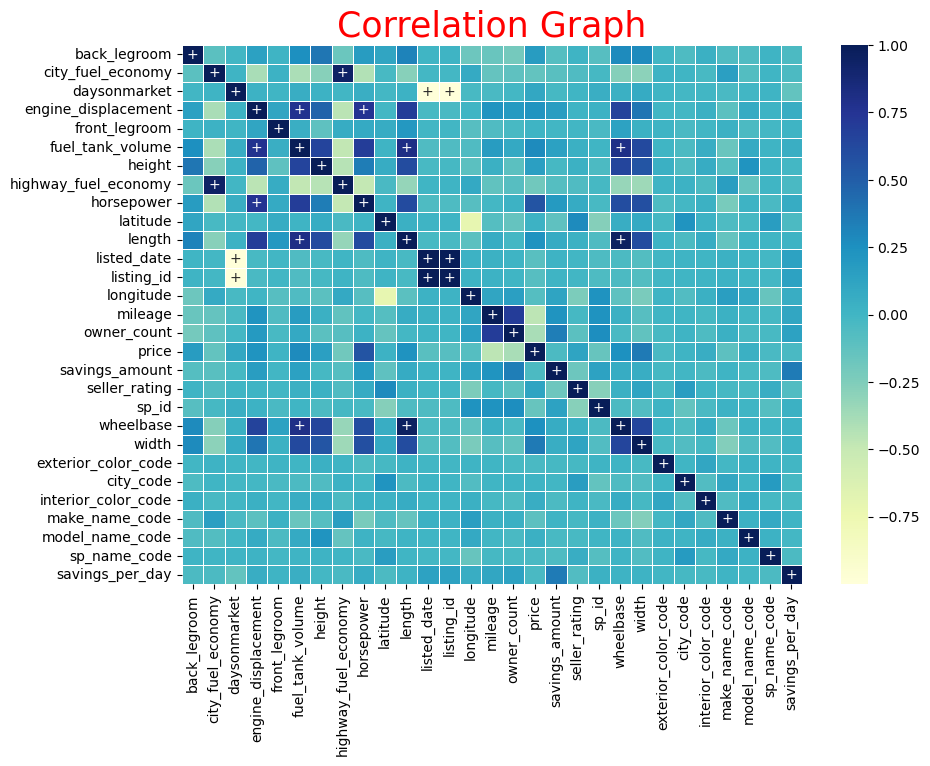

In [6]:
################################################################################
################################ CORRELATION ###################################
################################################################################

# Check which columns will be taken in for correlation function
print(cars.dtypes)
# Check for correlation in the data.
# Calculate the Pearson correlation coefficients for all covariates.
cor = cars.corr()
# Print the correlation coefficients
print(cor)

### custom_annotave - Custom annotating function.
#   INPUT:
#                     value - value of correlation to be highlighted;
#                     symbol - symbol to be used to highlight the values.
#   OUTPUT: 
#                     
def custom_annotate(value, symbol = "+"):
    if abs(value) >= 0.75:
        return symbol
    return ""

# Apply the custom annotating function to correlation data
annot = np.vectorize(custom_annotate)(cor)

# Plot the heatmap of correlations between variables.
# Plot size.
plt.figure(figsize = (10, 7))
# Plot the heatmap 
sns.heatmap(cor, annot = annot, cmap = "YlGnBu", linewidths = 0.5, fmt = "")
# Set heatmap title
plt.title("Correlation Graph", c = "r", size = 25)

## Pre-select Variables for The Model
Firstly, the correlation between variables and the end response value "price" is explored. Then the defined function important_variables() select a small handful of variables that have a specific correlation threshold. Another correlation plot for the selected variables is produced.

back_legroom            0.17
engine_displacement     0.23
fuel_tank_volume        0.28
height                  0.15
highway_fuel_economy   -0.19
horsepower              0.56
length                  0.24
mileage                -0.47
owner_count            -0.40
sp_id                  -0.16
wheelbase               0.25
width                   0.36
price                   1.00
Name: price, dtype: float64

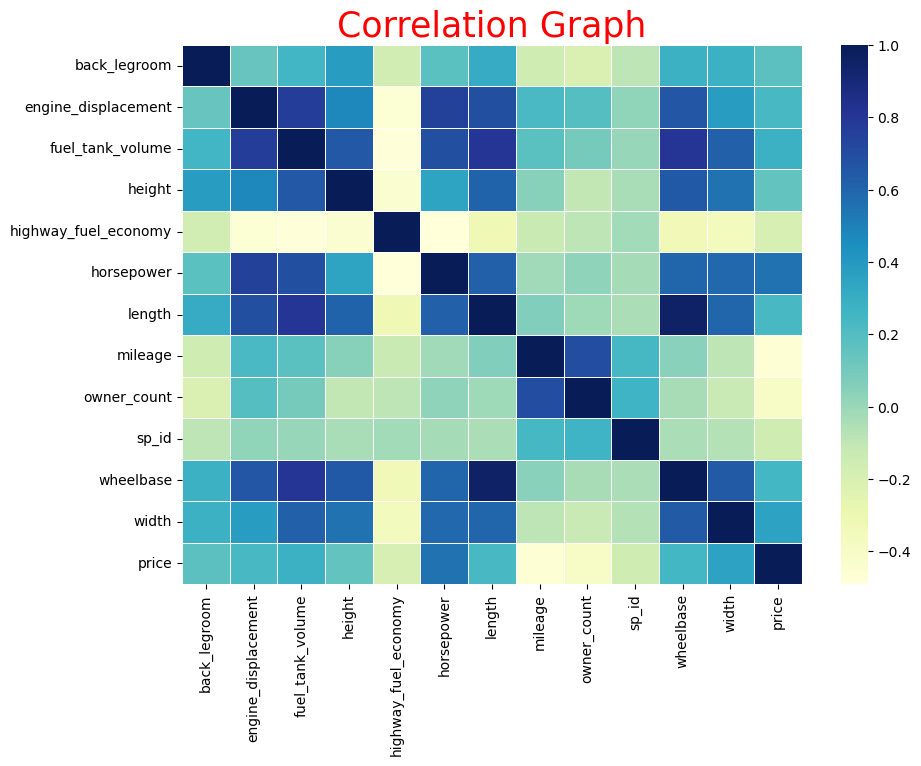

In [7]:
################################################################################
####################### SELECT VARIABLES FOR THE MODEL #########################
################################################################################

# First explore the relationship between the variables and the "price" 
# Get correlation matrix of selected variables and price
corr_matrix_price_initial = cars.corr()["price"]
# Print the matrix
corr_matrix_price_initial.round(2)

### important_variables - Function to select variables for the model.
#   INPUT:  
#                         corr_threshold - threshold of correlation with the price;
#                         data - data frame;
#   OUTPUT:
#                         cars_selected - updated data frame.
def important_variables(data = cars, corr_threshold = 0.2):
    
    # Firstly check if the input value is of correct type
    # Check if data is a data frame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input argument incorrect, it should be a Data Frame! :)")
    # Check if the data frame has more than 1 column
    if len(data.columns) < 2:
        raise ValueError("Your data frame has only 1 attribute! :O")
    # Check if the threshold value is numeric and its length is 1
    if not isinstance(corr_threshold, (int, float)) and len(str(corr_threshold))!= 1:
        raise TypeError("Input argument incorrect, it should be a numeric value! :)")
    # Check if the threshold value is greater than 0
    if corr_threshold <= 0:
        raise ValueError("Input argument incorrect, it should be a positive numeric value! :)")

    # Get correlation matrix of all pairs of variables
    corr_matrix = data.corr()["price"]
    # Pre-set a variable to store selection
    selected_vars = []
    cars_selected = pd.DataFrame()
    # Select the variables with correlation greater than or equal to the threshold
    for col in corr_matrix.index:
        if abs(corr_matrix[col]) >= corr_threshold and col != "price":
            selected_vars.append(col)

    # Add the prediction variable "price" to the selected variables and create a new data frame
    selected_vars.append("price")
    cars_selected = data[selected_vars]
    # Return the new data frame
    return cars_selected

# Get the new data frame with selected variables
cars_selected = important_variables(data = cars, corr_threshold = 0.15)

# Get correlation matrix of all pairs of variables
corr_matrix = cars_selected.corr()
# Plot heatmap of correlation.
# Plot size.
plt.figure(figsize = (10,7))
sns.heatmap(corr_matrix, annot = False, cmap = "YlGnBu", linewidths = 0.5, fmt = "+")
# Set heatmap title
plt.title("Correlation Graph", c = "r", size = 25)


# Get correlation matrix of selected variables and price
corr_matrix_price = cars_selected.corr()["price"]
# Print the matrix
corr_matrix_price.round(2)

## Split the Data Set into Training and Test

## Split the Data
Next step - splitting the data set into training and testing sets. The sets are split to have equal representation across the price categories. The price categories are defined by quantiles.

In [ ]:
################################################################################
###################### TRAINING AND TEST SETS SPLIT ############################
################################################################################

# To split the training from testing sections
from sklearn.model_selection import StratifiedShuffleSplit

# Check quantiles to then categorise the data in to 5 sections
cat = cars_selected["price"].describe()

# Create price_categ column to split the data into evenly distributed
# training and testing sets
# Split the data by "price" column into normally distributed 5 bins
cars_selected["price_categ"] = pd.qcut(cars_selected["price"], q = 5, labels = [1, 2, 3, 4, 5])
# Plot the category values in a histogram to check if it makes sense
cars_selected["price_categ"].hist()

# Split the training and the testing sets
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 7) # 7 being the lucky number
for train_index, test_index in split.split(cars_selected, cars_selected["price_categ"]):
    strat_train_set = cars_selected.loc[train_index]
    strat_test_set = cars_selected.loc[test_index]

# Check if the categorical split makes sense
price_distribution = strat_test_set["price"].value_counts() / len(strat_test_set)
# Plot the histogram of the price distribution
price_distribution.hist()

# Check the proportions of each price category in the training and testing sets
print(strat_train_set["price_categ"].value_counts(normalize = True))
print(strat_test_set["price_categ"].value_counts(normalize =True))

# Plot histograms of price_categ in the original data, training, and testing sets
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
cars_selected["price_categ"].hist(ax = ax[0], bins = 5, color = "orange", edgecolor = "darkgoldenrod")
ax[0].set_title("Original Data")
ax[0].set_ylim([5500, 5650])
strat_train_set["price_categ"].hist(ax = ax[1], bins = 5, color = "orange", edgecolor = "darkgoldenrod")
ax[1].set_title("Training Set")
ax[1].set_ylim([4400, 4500])
strat_test_set["price_categ"].hist(ax = ax[2], bins = 5, color = "orange", edgecolor = "darkgoldenrod")
ax[2].set_title("Testing Set")
ax[2].set_ylim([1100, 1130])
# Overall subtitle
fig.suptitle("Distribution of Price Categories", fontsize = 14)

# Drop the category column as it should not predict anything in the model
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("price_categ", axis = 1, inplace = True)

# Split the predictors from the target
# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

## Scale the Data Sets
As the data has been split, the next step is to scale the data sets (separately). The section below prepares pipelines to do so.

In [ ]:
################################################################################
############################## FEATURE SCALING #################################
################################################################################

# Import the standard scaler and pipeline functions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Import the function to fill in any missing numeric values
from sklearn.impute import SimpleImputer 

# Define the NA's imputer
imputer = SimpleImputer(strategy = "median")
# Build pipeline to scale the data set
num_pipeline = Pipeline([
    ("imputer", imputer),
    ("std_scaler", StandardScaler()),
    ])

# Import the column transformer
from sklearn.compose import ColumnTransformer
# Select the columns to be scaled
num_cols = strat_train_set.select_dtypes(include = np.number).columns.tolist()
# Column transformer pipeline, full
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

## Model Fitting
#### Linear Regression
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold), Akaike Information Criterion (AIC).

In [ ]:
################################################################################
########################## LINEAR REGRESSION MODEL #############################
################################################################################

###################### FIT AND TRANSFORM THE DATA SETS #########################

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import the linear regression functions
from sklearn.linear_model import LinearRegression 
# Save the linear regression function
lin_reg = LinearRegression()
# Fit the first linear regression model
lin_reg.fit(X_train_transformed, y_train)

# Check predictions for the first 5 rows in the training set
print("Training set predictions:")
print(lin_reg.predict(X_train_transformed[:5]))
# Check predictions for the first 5 rows in the test set
print("Test set predictions:")
print(lin_reg.predict(X_test_transformed[:5]))
# Seems the regression predictions are working, now we need to evaluate the model

############################# EVALUATE THE MODEL ###############################

### R-SQUARED SCORE

# Calculate R-squared score for the trained model on the test dataset
y_test_pred = lin_reg.predict(X_test_transformed)
# R-squared metric to check the model performance
from sklearn.metrics import r2_score
# Calculate the R-squared score
r2 = r2_score(y_test, y_test_pred)
# Print the score
print("R-squared model 1:", r2)

### RMSE

# Import the MSE function
from sklearn.metrics import mean_squared_error
# Compute the MSE
lin_mse = mean_squared_error(y_test, y_test_pred) 
# Compute the RMSE
lin_rmse = np.sqrt(lin_mse)
# Print the score
print("RMSE model 1:", lin_rmse)

### MAE

# Import the MAE function
from sklearn.metrics import mean_absolute_error

# Print MAE score
print("MAE model 1: ", mean_absolute_error(y_test, y_test_pred))

### CROSS VALIDATION 

# Import the cross validation function
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross-validation on the linear regression model
scores = cross_val_score(lin_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
tree_rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(tree_rmse_scores)

### AIC

# Import the AIC function
import statsmodels.api as sm

# Fit the linear regression model using statsmodels function
# Add the constant term for intercept
X_train_sm = sm.add_constant(X_train_transformed)  
lin_reg_sm = sm.OLS(y_train, X_train_sm)
lin_reg_sm_fit = lin_reg_sm.fit()

# Print the AIC score
print("AIC model 1:", lin_reg_sm_fit.aic)


#### Linear Regression Reduced
Automated selection of the variables is performed. Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold), Akaike Information Criterion (AIC), VIF.

In [ ]:
########################## REDUCE MODEL COMPLEXITY #############################

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import the function to reduce the complexity of the model
from sklearn.feature_selection import SelectFromModel

# Fit a linear regression model to obtain feature importances
lin_reg.fit(X_train_transformed, y_train)
importances = lin_reg.coef_

# Select features based on their importance score
selector = SelectFromModel(estimator=lin_reg, threshold = "median")
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)
# Train a new model on the selected features
lin_reg_selected = LinearRegression()
lin_reg_selected.fit(X_train_selected, y_train)

# Evaluate the performance of the new model
y_pred_selected = lin_reg_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)

# Get the names of the selected features
selected_features = selector.get_support(indices = True)
feature_names = list(strat_train_set.columns[selected_features])

###################### FIT AND TRANSFORM THE DATA SETS #########################
### Fit the new training set only using the selected variables

# Reconstruct the pipeline (FOR SOME REASON NUM_COLS = FEATURE_NAMES DID NOT WORK??)
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, feature_names)
])

# Train set
X_train = strat_train_set[num_cols].copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set[num_cols].copy()
y_test = strat_test_set["price"].copy()

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)
# Fit the updated linear regression model
lin_reg.fit(X_train_transformed, y_train)

############################# EVALUATE THE MODEL ###############################

### R-SQUARED SCORE

# Calculate R-squared score for the trained model on the test dataset
y_test_pred = lin_reg.predict(X_test_transformed)
# Calculate the R-squared score
r2_selected = r2_score(y_test, y_test_pred)
# Print the score
print("R-squared model 2:", r2_selected) # Score: 1.0

### RMSE

# Extract predictions from the training set
price_predictions = lin_reg.predict(X_train_transformed)
# Compute the MSE
lin_mse = mean_squared_error(y_train, price_predictions) 
# Compute the RMSE
lin_rmse = np.sqrt(lin_mse)
# Print the score
print("RMSE model 2:", lin_rmse)

### MAE

# Print MAE score
print("MAE model 2: ", mean_absolute_error(y_train, price_predictions))

### AIC

# Fit the linear regression model using statsmodels function
# Add the constant term for intercept
X_train_sm = sm.add_constant(X_train_transformed)  
lin_reg_sm = sm.OLS(y_train, X_train_sm)
lin_reg_sm_fit = lin_reg_sm.fit()

# Print the AIC score
print("AIC model 2:", lin_reg_sm_fit.aic)

### VISUAL EVALUATION

# Plot given prices against predicted prices
plt.scatter(y_test, y_test_pred)
# Plot the line
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], "k--", lw = 3)
# Labels
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")

### CROSS VALIDATION SCORE

# Perform 10-fold cross-validation on the linear regression model
scores = cross_val_score(lin_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(rmse_scores)

### VIF

### Check variance inflation factor
# Import the functions for VIF
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe to store the VIFs 
vif_df = pd.DataFrame(columns = ["predictor", "VIF"])

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns = feature_names)

# Calculate the VIF for each feature
for i in range(len(feature_names)):
    vif = variance_inflation_factor(X_train_df[feature_names].values, i)
    feature_name = feature_names[i]
    vif_df.loc[i] = [feature_name, vif]

# Print the VIF dataframe
print(vif_df)

#### Ridge Regression
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold), Akaike Information Criterion (AIC).

In [ ]:
################################################################################
############################## RIDGE REGRESSION ################################
################################################################################

# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import Ridge function 
from sklearn.linear_model import Ridge
# Import grid search to find the optimal alpha value
from sklearn.model_selection import GridSearchCV
# Define the Ridge regression model
ridge_reg = Ridge()

################################ GRID SEARCH ##################################

# Grid values
param_grid = {"alpha": np.arange(0.001, 1.02, 0.002)}
grid_search = GridSearchCV(ridge_reg, param_grid, cv = 10)
# Fit the grid
grid_search.fit(X_train_transformed, y_train)
# Print the best alpha value
print("Best alpha value: ", grid_search.best_params_["alpha"])

############################### FIT BEST ALPHA #################################

# Define the Ridge regression model
ridge_reg = Ridge(alpha = grid_search.best_params_["alpha"])
# Fit the pipeline to the training data
ridge_reg.fit(X_train_transformed, y_train)
# Ridge model predictions
ridge_y_pred = ridge_reg.predict(X_test_transformed)

############################# EVALUATE THE MODEL ###############################

# R2, RMSE, MAE
print("R2 score Ridge model: ", r2_score(y_test, ridge_y_pred))
print("RMSE Ridge model: ", np.sqrt(mean_squared_error(y_test, ridge_y_pred)))
print("MAE Ridge model: ", mean_absolute_error(y_test, ridge_y_pred))
# Perform 10-fold cross-validation on the linear ridge model
scores = cross_val_score(ridge_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(rmse_scores)

# AIC
# Get the number of features in the model
num_feat = X_train_transformed.shape[1]
# Calculate the residual sum of squares
rss = np.sum((y_train - ridge_reg.predict(X_train_transformed)) ** 2)
# Calculate the AIC score
aic = 2 * num_feat + len(y_train) * np.log(rss / len(y_train))
# Print AIC score
print("AIC score Ridge model: ", aic)

#### Lasso Regression
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold), Akaike Information Criterion (AIC), VIF.

In [ ]:
################################################################################
############################## LASSO REGRESSION ################################
################################################################################

# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import Lasso function 
from sklearn.linear_model import Lasso
# Define the Lasso regression model
lasso_reg = Lasso()

################################ GRID SEARCH ##################################

# Grid values
param_grid = {"alpha": np.arange(0.001, 1.02, 0.002)}
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10)
# Fit the grid
grid_search.fit(X_train_transformed, y_train)
# Print the best alpha value
print("Best alpha value: ", grid_search.best_params_["alpha"])

############################### FIT BEST ALPHA #################################

# Define the Lasso regression model
lasso_reg = Lasso(alpha = grid_search.best_params_["alpha"])
# Fit the pipeline to the training data
lasso_reg.fit(X_train_transformed, y_train)
# Lasso model predictions
lasso_y_pred = lasso_reg.predict(X_test_transformed)

############################# EVALUATE THE MODEL ###############################

# R2, RMSE, MAE
print("R2 score Lasso model: ", r2_score(y_test, lasso_y_pred))
print("RMSE Lasso model: ", np.sqrt(mean_squared_error(y_test, lasso_y_pred)))
print("MAE Lasso model: ", mean_absolute_error(y_test, lasso_y_pred))

# Perform 10-fold cross-validation on the linear regression model
scores = cross_val_score(lasso_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(rmse_scores)

# AIC
# Get the number of features in the model
num_feat = X_train_transformed.shape[1]
# Calculate the residual sum of squares
rss = np.sum((y_train - lasso_reg.predict(X_train_transformed)) ** 2)
# Calculate the AIC score
aic = 2 * num_feat + len(y_train) * np.log(rss / len(y_train))
# Print AIC score
print("AIC score Lasso model: ", aic)

### VIFs

# Create a dataframe to store the VIFs 
vif_df = pd.DataFrame(columns = ["predictor", "VIF"])

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns = num_cols)

# Calculate the VIF for each feature
for i in range(len(num_cols)):
    vif = variance_inflation_factor(X_train_df[num_cols].values, i)
    col = num_cols[i]
    vif_df.loc[i] = [col, vif]

# Print the VIF dataframe
print(vif_df)
# Wheelbase and length variables have strong VIF of more than 13 (both)
#       wheelbase will be eliminated for the final model.

#### Decision Tree
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold).

In [ ]:
################################################################################
############################### DECISION TREE ##################################
################################################################################

# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import DecisionTreeRegressor function
from sklearn.tree import DecisionTreeRegressor
# Define the decision tree regression model
tree_reg = DecisionTreeRegressor()
# Fit the pipeline to the training data
tree_reg.fit(X_train_transformed, y_train)
# Predictions
tree_y_pred = tree_reg.predict(X_test_transformed)

# R2, RMSE, MAE
print("R2 score Decision Tree model: ", r2_score(y_test, tree_y_pred))
print("RMSE Decision Tree model: ", np.sqrt(mean_squared_error(y_test, tree_y_pred)))
print("MAE Decision Tree model: ", mean_absolute_error(y_test, tree_y_pred))

# Perform 10-fold cross-validation on the decision tree model
scores = cross_val_score(tree_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(rmse_scores)

#### Random Forest
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold).

In [ ]:
################################################################################
########################## RANDOM FOREST REGRESSOR #############################
################################################################################

# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import random forest regressor function
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_transformed, y_train)
forest_y_pred = tree_reg.predict(X_test_transformed)

# R2, RMSE, MAE
print("R2 score Forest Tree model: ", r2_score(y_test, forest_y_pred))
print("RMSE Forest Tree model: ", np.sqrt(mean_squared_error(y_test, forest_y_pred)))
print("MAE Forest Tree model: ", mean_absolute_error(y_test, forest_y_pred))

# Perform 10-fold cross-validation on the forest tree model
scores = cross_val_score(tree_reg, X_train_transformed, y_train,
                             scoring = "neg_mean_squared_error", cv = 10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

#### Random Forest. Fine Tuning
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold).

In [ ]:
################################################################################
##################### FINE TURE RANDOM FOREST REGRESSOR ########################
################################################################################

# Train set
X_train = strat_train_set.copy()
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
y_test = strat_test_set["price"].copy()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)


############################### GRID SEARCH #####################################

# Set parameter grids
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]
# Build grid search with parameters
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                           scoring = "neg_mean_squared_error",
                           return_train_score = True)
grid_search.fit(X_train_transformed, y_train)
# Get the best parameters
grid_search.best_params_

################################### EVALUATION ##################################

# Get the CV results
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# It's performing a lot poorer than the initial model (though the mean value 
#    probably fits within the standard deviation)

## Final Model - Lasso with Selected Variables
Fitting in the model, evaluating it with R-squared, Root Mean Squared Error, Mean Absolute Error, Cross Validation (10 fold), Akaike Information Criterion (AIC), VIF. Wheelbase variable is dropped as of high VIF.

In [ ]:
################################################################################
################################# FINAL MODEL ##################################
################################################################################

# Train set
X_train = strat_train_set.copy()
X_train.drop("wheelbase", axis = 1, inplace = True)
y_train = strat_train_set["price"].copy()
# Test set
X_test = strat_test_set.copy()
X_test.drop("wheelbase", axis = 1, inplace = True)
y_test = strat_test_set["price"].copy()

# Vector of final variable names
final_cols = X_train.select_dtypes(include = np.number).columns.tolist()

# Rewrite the pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, final_cols)
])

# Transform the training and test sets
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

# Import Lasso function 
from sklearn.linear_model import Lasso
# Define the Lasso regression model
lasso_reg = Lasso()

################################ GRID SEARCH ##################################

# Grid values
param_grid = {"alpha": np.arange(0.001, 1.02, 0.002)}
grid_search = GridSearchCV(lasso_reg, param_grid, cv = 10)
# Fit the grid
grid_search.fit(X_train_transformed, y_train)
# Print the best alpha value
print("Best alpha value: ", grid_search.best_params_["alpha"])

############################### FIT BEST ALPHA #################################

# Define the Lasso regression model
lasso_reg = Lasso(alpha = grid_search.best_params_["alpha"])
# Fit the pipeline to the training data
lasso_reg.fit(X_train_transformed, y_train)
# Lasso model predictions
lasso_y_pred = lasso_reg.predict(X_test_transformed)

############################# EVALUATE THE MODEL ###############################

# R2, RMSE, MAE
print("R2 score Lasso model: ", r2_score(y_test, lasso_y_pred))
print("RMSE Lasso model: ", np.sqrt(mean_squared_error(y_test, lasso_y_pred)))
print("MAE Lasso model: ", mean_absolute_error(y_test, lasso_y_pred))

# Perform 10-fold cross-validation on the linear regression model
scores = cross_val_score(lasso_reg, X_train_transformed, y_train, \
                         cv = 10, scoring = "neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)
# Define display cv scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
# Print the cross-validation scores and their mean
display_scores(rmse_scores)

# AIC
# Get the number of features in the model
num_feat = X_train_transformed.shape[1]
# Calculate the residual sum of squares
rss = np.sum((y_train - lasso_reg.predict(X_train_transformed)) ** 2)
# Calculate the AIC score
aic = 2 * num_feat + len(y_train) * np.log(rss / len(y_train))
# Print AIC score
print("AIC score Lasso model: ", aic)

### VIFs

# Create a dataframe to store the VIFs 
vif_df = pd.DataFrame(columns = ["predictor", "VIF"])

# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns = final_cols)

# Calculate the VIF for each feature
for i in range(len(final_cols)):
    vif = variance_inflation_factor(X_train_df[final_cols].values, i)
    col = final_cols[i]
    vif_df.loc[i] = [col, vif]

# Print the VIF dataframe
print(vif_df)
# Wheelbase and length variables have strong VIF of more than 13 (both)
#       wheelbase will be eliminated for the final model.

## Final Model Further Evaluation
Extracting beta coefficients, computing RMSE Confidence Intervals, visual evaluation.

In [ ]:
################################################################################
############################ FINAL MODEL EVALUATION ############################
################################################################################

### COEFFICIENTS

# Get feature importances
coef_abs = np.abs(lasso_reg.coef_)
feature_importances = coef_abs / np.sum(coef_abs)

# Sort features by importance
sorted_features = sorted(zip(feature_importances, final_cols), reverse = True)
print(sorted_features)

# Most of the variable coefficients come down to 0, which is concerning

### RMSE CIs

# Get the confidence intervals of RMSE
from scipy import stats
confidence = 0.95
squared_errors = (lasso_y_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc = squared_errors.mean(),
scale = stats.sem(squared_errors)))

############################### VISUAL EVALUATION ##############################

### Observed vs actual prices

# Plot the predicted values against the actual values of test set
plt.scatter(y_test, lasso_y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
# Add a line representing the perfect prediction line
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color = "red")

### Residuals goodness-of-fit

# Create a dataframe with the predicted and original values
residuals_df = pd.DataFrame({"y_test": y_test, "lasso_y_pred": lasso_y_pred})
# Add a column for the residuals
residuals_df["residuals"] = residuals_df["y_test"] - residuals_df["lasso_y_pred"]
# Define plot colors
scatter_color = "#2c7fb8"
line_color = "#d95f0e"
# Plot the residuals with customized colors and labels
sns.residplot(x = "lasso_y_pred", y = "residuals", data = residuals_df, lowess = True, 
              scatter_kws = {"color": scatter_color}, line_kws={"color": line_color})
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")